## 0. Preliminary imports

In [1]:
import pandas as pd
import numpy as np
import torch
import nltk
from sklearn.preprocessing import LabelEncoder
from transformers import CamembertTokenizer, CamembertForSequenceClassification, FlaubertTokenizer, FlaubertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict

nltk.download('punkt')
nltk.download('stopwords')

# Load French stopwords
stop_words = set(stopwords.words('french'))
color = 'deeppink'


[nltk_data] Downloading package punkt to /Users/vaienti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vaienti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Read and clean the training data
We read the training data (training_data.csv), remove the rows with missing values, drop the duplicate rows and reset the index.

The training data contains sentences ('sentence') and their corresponding A1, ..., C2 label for the difficulty ('difficulty').

In [2]:
# we read the training data
df = pd.read_csv('../training/training_data.csv')
# Drop rows with missing 'sentence' or 'difficulty' in training data
df = df.dropna(subset=['sentence', 'difficulty'])
# remove duplicates
df = df.drop_duplicates(subset=['sentence'])
df.reset_index(drop=True, inplace=True)

## 2. Read the test data
In this case we don't drop any columns, since we want to predict the difficulty of all the sentences. We won't do any data cleaning.

In [3]:
# Load the test dataset
inference = pd.read_csv('../test/unlabelled_test_data.csv')

## 3. Data Augmentation
We will enhance our dataset by adding additional features deriving from the original text. We will use the following features:
- **Number of words** in each sentence ('n_words');
- **Average word length** in each sentence excluding stopwords ('avg_word_length');
- **Part-of-Speech (POS) tags** representing the syntactic role of each word in the sentence and the frequency of each tag;


(- **Cognates** - similar words between french and english which could influence the perceived difficulty of the sentence;)


We will add these features, if relevant, to the training and test data.

### 3.1 Number of words

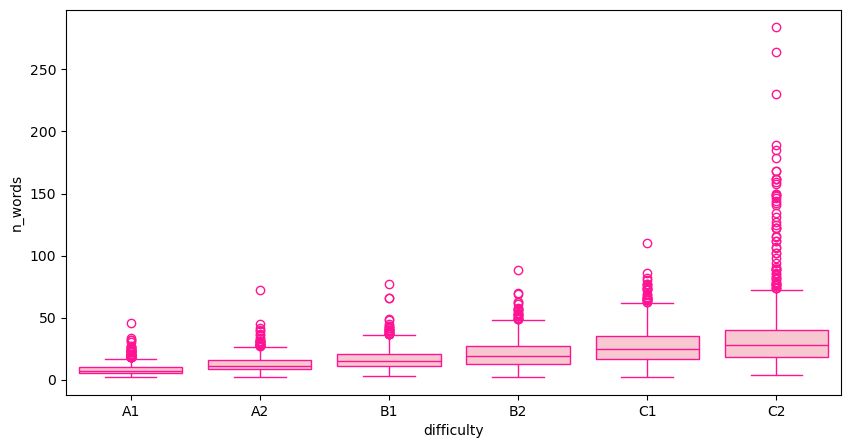

In [10]:
# 1. we add a column with the number of words in the text ('sentence' column)

def add_n_words(df):
    df['n_words'] = df['sentence'].apply(lambda x: len(word_tokenize(x)))
    return df

df = add_n_words(df)
inference = add_n_words(inference)

# let's visualize the correlation between the number of words and the difficulty
plt.figure(figsize=(10, 5))
# order the x-axis by difficulty
difficulty_order = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']  

sns.boxplot(x='difficulty', y='n_words', data=df, color = 'pink', linecolor = color, order=difficulty_order)
plt.show()


There is a correlation between the number of words in a sentence and the difficulty of the sentence, so this feature could be useful.


### 3.2 Average word length
Calculated after removing stopwords.

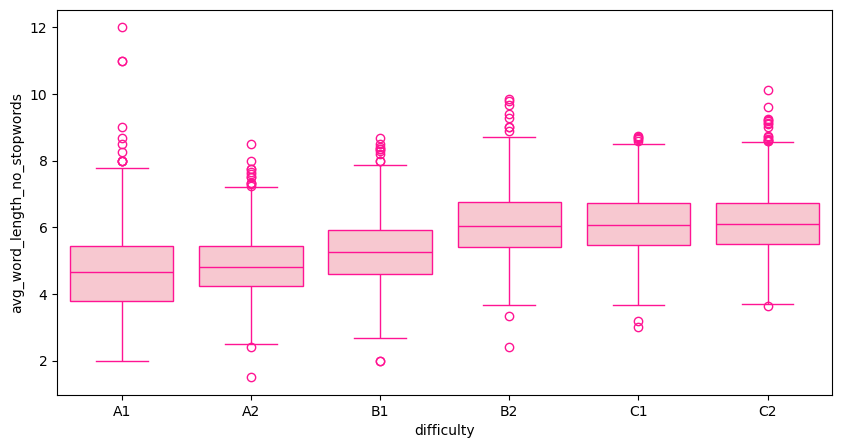

In [11]:
# Function to calculate average word length excluding stopwords
def avg_word_length_no_stopwords(sentence):
    words = word_tokenize(sentence)
    words_no_stopwords = [word for word in words if word.lower() not in stop_words]
    if len(words_no_stopwords) > 0:
        avg_length = sum(len(word) for word in words_no_stopwords) / len(words_no_stopwords)
    else:
        avg_length = 0  # To handle cases where all words are stopwords
    return avg_length

def add_avg_word_length_no_stopwords(df):
    df['avg_word_length_no_stopwords'] = df['sentence'].apply(avg_word_length_no_stopwords)
    return df

df = add_avg_word_length_no_stopwords(df)
inference = add_avg_word_length_no_stopwords(inference)

# let's visualize the correlation between the average word length and the difficulty
plt.figure(figsize=(10, 5))
sns.boxplot(x='difficulty', y='avg_word_length_no_stopwords', data=df, color = 'pink', linecolor = color, order=difficulty_order)
plt.show()


There is a correlation between the average word lenght and the difficulty, so we will keep this feature.

### 3.3 Part-of-Speech (POS) tags
We analyze the sentences and extract the POS tags for each word (after removing stopwords). Tags represent the syntactic role of each word in the sentence. We calculate the frequency of each tag. 

However, we won't use all the tags, but only the most relevant ones, chosen as the first 10 tags with the highest frequency. 

# todo: see if the pos tagging is better with camembert

Top POS tags: ['NN', 'JJ', 'NNS', ',', '.']


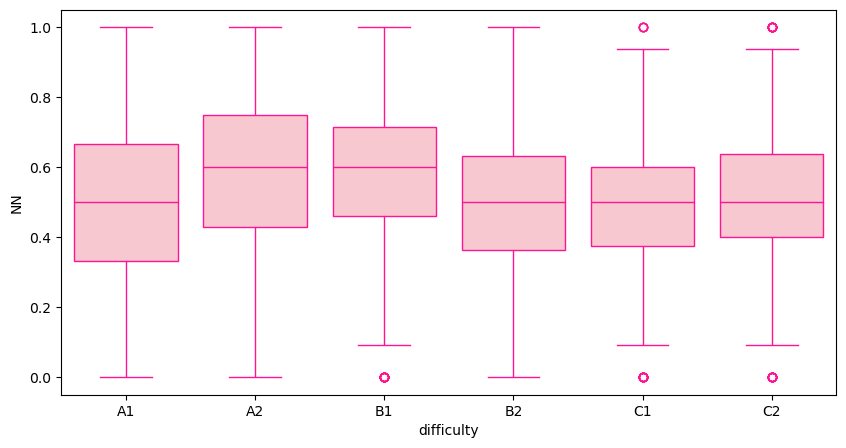

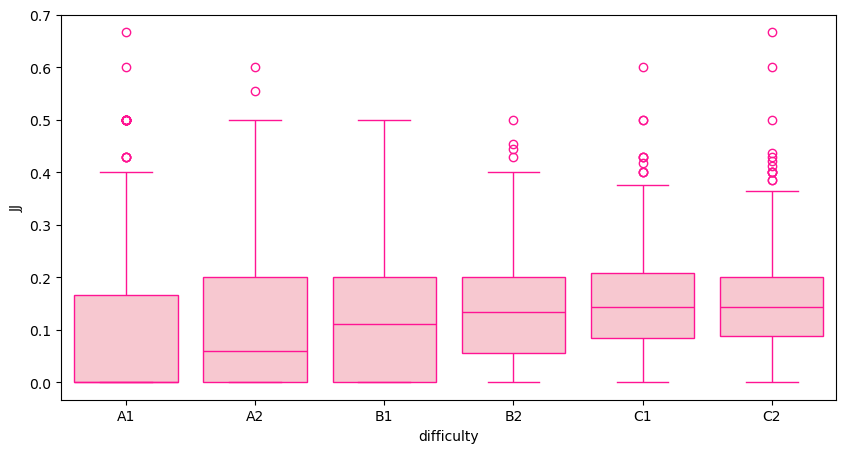

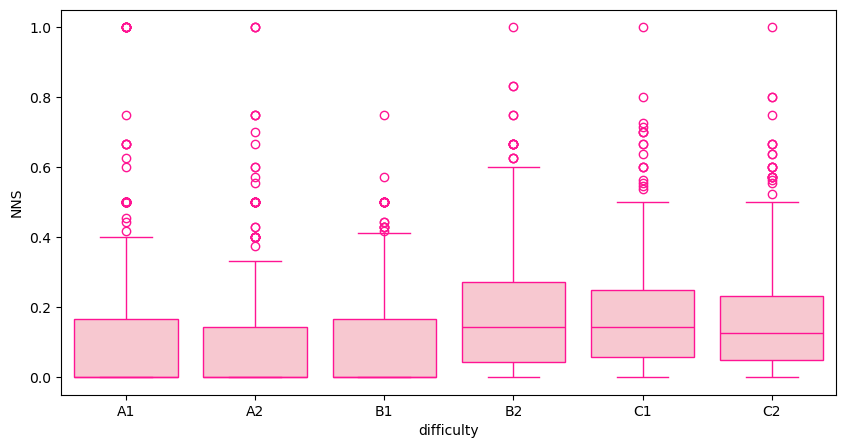

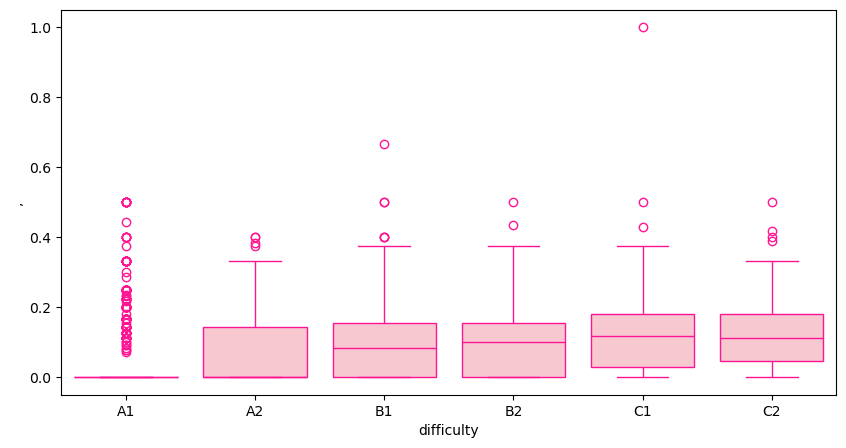

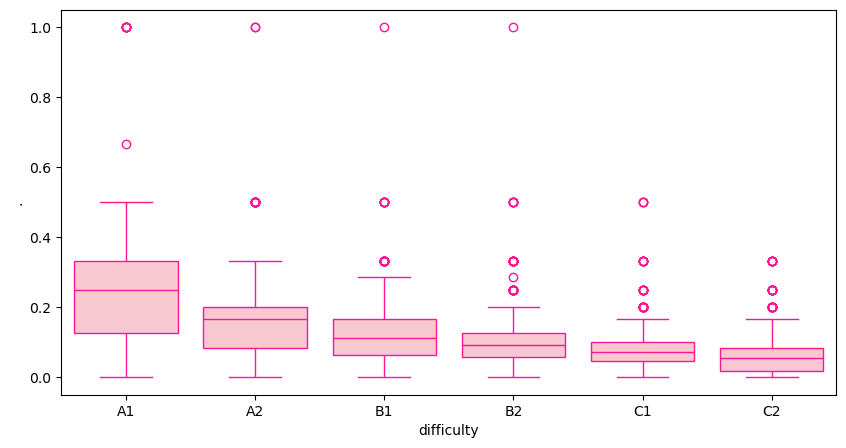

In [13]:
# Function to calculate frequencies of POS tags in a sentence, excluding specific tags
def get_tag_counts(sentences, exclude_tags={}):
    tag_counts = defaultdict(int)
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        tokens_no_stopwords = [word for word in tokens if word.lower() not in stop_words]
        pos_tags = pos_tag(tokens_no_stopwords)
        for _, tag in pos_tags:
            if tag not in exclude_tags:
                tag_counts[tag] += 1
    return tag_counts

def pos_counts(sentence, top_tags, exclude_tags=None):
    if exclude_tags is None:
        exclude_tags = {}  # Include typical punctuation to exclude by default
    tokens = word_tokenize(sentence)
    tokens_no_stopwords = [word for word in tokens if word.lower() not in stop_words]
    pos_tags = pos_tag(tokens_no_stopwords)
    pos_counts = defaultdict(int)
    total_counts = 0

    # Count only relevant POS tags
    for _, tag in pos_tags:
        if tag not in exclude_tags and tag in top_tags:
            pos_counts[tag] += 1
            total_counts += 1

    # Convert counts to frequencies, safely handling division by zero
    pos_frequencies = {tag: (pos_counts[tag] / total_counts if total_counts > 0 else 0) for tag in top_tags}
    return pos_frequencies

def add_pos_counts(df, top_tags):
    # Apply the function to the DataFrame
    df['pos_counts'] = df['sentence'].apply(lambda x: pos_counts(x, top_tags))

    # Expand the pos_counts dictionary into separate columns
    for tag in top_tags:
        df[tag] = df['pos_counts'].apply(lambda x: x.get(tag, 0))
    
    # Drop the pos_counts column if no longer needed
    df.drop(columns=['pos_counts'], inplace=True)
    
    return df

all_sentences = df['sentence'].tolist() + inference['sentence'].tolist()  # Combining sentences from both datasets
total_tag_counts = get_tag_counts(all_sentences) 

# Select the top N most frequent tags, e.g., top 5
top_tags = sorted(total_tag_counts.items(), key=lambda x: x[1], reverse=True)[:5]
top_tags = [tag for tag, count in top_tags]
print("Top POS tags:", top_tags)

# Apply the function to the test and training datasets
df = add_pos_counts(df, top_tags)
inference = add_pos_counts(inference, top_tags)

# Let's visualize the correlation between the top POS tags and the difficulty
difficulty_order = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']  
for tag in top_tags:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='difficulty', y=tag, data=df, order=difficulty_order, color = 'pink', linecolor = color)
    plt.show()

## 4. Processing of the sentences
After adding the new features, we will process the sentences in order to be able to use them in the model and to improve the model's performance. In particular we want to create embeddings for the sentences using the CamemBERT/FlauBERT model.


We will:
- Apply tokenization using the CamemBERT/FlauBERT tokenizer;
- Pad the sequences to the same length;
- Create the attention masks;
- Create the embeddings for the sentences using the CamemBERT/FlauBERT model.

Since we are using CamemBERT and FlauBERT, we won't apply lemmatization or stemming, or remove stopwords, since these models are working with contextual words.



### 4.1 Selection of the model and tokenizer
First, we need to choose the model between 'camembert' and 'flaubert'. 

In [15]:
chosen_tokenizer = 'camembert'

def get_tokenizer_model(chosen_tokenizer, num_classes):
    if chosen_tokenizer == 'camembert':
        tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
        model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=num_classes)
    elif chosen_tokenizer == 'flaubert':
        tokenizer = FlaubertTokenizer.from_pretrained('flaubert/flaubert_base_cased')
        model = FlaubertForSequenceClassification.from_pretrained('flaubert/flaubert_base_cased', num_labels=num_classes)
    return tokenizer, model

num_classes = df['difficulty'].nunique()
tokenizer, model = get_tokenizer_model(chosen_tokenizer, num_classes)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.2 Attention Masking and Padding
To apply the tokenizer, the padding and the attention masks we create a class CEFRDataset that will be used to process the training and test datasets and to convert the sentences into embeddings.

In [46]:


class CEFRDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len, labels=None):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        # Add labels to your dataset only if they are provided, i.e., during training and validation.
        if self.labels is not None:
            label = self.labels[idx]
            item['labels'] = torch.tensor(label, dtype=torch.long)
        return item


dataset = CEFRDataset(df['sentence'], tokenizer, max_len=128, labels=y_encoded)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['▁Ceci', '▁est', '▁une', '▁phrase', '▁française', '.']


# Preprocessing of the target variable
## 1. Label encoding of the target variable
The target variable contains the difficulty levels as strings (A1, A2, B1, B2, C1, C2). We convert these strings to integers using the LabelEncoder from the scikit-learn library.

In [9]:
y = df['difficulty'].values

# Define the order of your labels
labels_ordered = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Manually fit the encoder to the ordered labels
encoder.fit(labels_ordered)

# Encode your actual labels
y_encoded = encoder.transform(y)

# Output the encoding to verify
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Label mapping:", label_mapping)
print(y, y_encoded)

Label mapping: {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
['C1' 'A1' 'A1' ... 'A2' 'C2' 'C2'] [4 0 0 ... 1 5 5]
